# Recurrent Neural Network (RNN) Models

**Goal**: Test if temporal models can beat Random Forest (93.0%) by exploiting sequential structure.

## Why RNNs for This Problem?

**Key insight from previous notebooks**:
- Labels are **reactive control signals** (temporal lag problem)
- Single frames don't explain labels - need to see vehicle **drifting** over time
- EDA showed high temporal correlation (frames within 100 steps correlated)

**How RNNs help**:
- Process **sequences** of frames (not single frames)
- Can see vehicle drift happening: frame₁ (centered) → frame₂ (drifting right) → predict "turn left"
- Memory of past frames helps understand current steering decision

## What are RNNs/GRU/LSTM?

**Recurrent Neural Network (RNN)**:
- Processes sequences one frame at a time
- Maintains "memory" (hidden state) of what it saw before
- Formula: `hidden_t = f(input_t, hidden_t-1)`
- **Problem**: Vanishing gradients (forgets long-ago frames)

**GRU (Gated Recurrent Unit)**:
- Improved RNN with "gates" that control memory
- Decides what to remember and what to forget
- **Simpler** than LSTM (fewer parameters)
- Often works better on small datasets

**LSTM (Long Short-Term Memory)**:
- Most sophisticated RNN variant
- Separate "memory cell" + 3 gates (forget, input, output)
- Can remember long sequences
- **More parameters** - may overfit on small data

## Experiment Design

**Window sizes**: 10, 20, 30 frames
- 10 frames: ~0.5 seconds of driving (immediate context)
- 20 frames: ~1.0 seconds (full turn sequence)
- 30 frames: ~1.5 seconds (might be too long)

**Models**: Basic RNN, GRU, LSTM

**Total experiments**: 3 × 3 = 9 models

**Baseline to beat**: Random Forest 93.0% / 0.910 F1-Macro

## 1. Setup

In [18]:
# Force CPU mode (GPU setup issues)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

plt.style.use('default')
%matplotlib inline

label_names = {-1: 'Left', 0: 'Forward', 1: 'Right'}

print(f"TensorFlow version: {tf.__version__}")
print("Running on CPU (GPU disabled)")
print("Estimated time: 30-60 minutes for 9 models")

TensorFlow version: 2.14.0
Running on CPU (GPU disabled)
Estimated time: 30-60 minutes for 9 models


## 2. Load Data

In [19]:
# Load temporal splits (no class balancing - proven ineffective)
data = np.load('../data/splits_temporal.npz')

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

# Normalize
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Map labels: -1→0, 0→1, 1→2
y_train_mapped = y_train + 1
y_val_mapped = y_val + 1
y_test_mapped = y_test + 1

print(f"Train: {X_train.shape}, labels: {Counter(y_train)}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

Train: (5940, 64, 64), labels: Counter({0: 4252, -1: 1033, 1: 655})
Val:   (1980, 64, 64)
Test:  (1980, 64, 64)


## 3. Create Sequences

**Transform data**: From single frames to sequences of frames

**Example** (window=10):
- Input: frames [0,1,2,3,4,5,6,7,8,9] → Predict: label at frame 9
- Input: frames [1,2,3,4,5,6,7,8,9,10] → Predict: label at frame 10

**Sliding window approach**: Create overlapping sequences

In [20]:
def create_sequences(X, y, window_size=10):
    """
    Create sequences from frames.
    
    Args:
        X: Images (samples, height, width)
        y: Labels
        window_size: Number of frames in each sequence
    
    Returns:
        X_seq: (samples, window_size, height, width)
        y_seq: Labels for last frame in each sequence
    """
    X_seq = []
    y_seq = []
    
    for i in range(len(X) - window_size + 1):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size-1])  # Label of last frame
    
    return np.array(X_seq), np.array(y_seq)

print("Sequence creation function defined")

Sequence creation function defined


In [21]:
# DON'T create all sequences at once (GPU memory issue)
# We'll create them on-demand during training
window_sizes = [2, 3, 4]
print(f"Window sizes to test: {window_sizes}")
print("Sequences will be created on-demand to save memory")

Window sizes to test: [2, 3, 4]
Sequences will be created on-demand to save memory


## 4. Model Builders

**Architecture for all RNN variants**:
- Input: Sequence of frames
- Flatten each frame: 64×64 → 4096 features
- RNN/GRU/LSTM layer: Process sequence
- Dense layer: Final classification

**Small architectures** to avoid overfitting (learned from CNN experiments)

In [22]:
def build_basic_rnn(window_size=10, units=64):
    model = models.Sequential([
        layers.Input(shape=(window_size, 64, 64)),
        layers.Reshape((window_size, 64*64)),
        layers.SimpleRNN(units, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_gru(window_size=10, units=64):
    model = models.Sequential([
        layers.Input(shape=(window_size, 64, 64)),
        layers.Reshape((window_size, 64*64)),
        layers.GRU(units, activation='tanh'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_lstm(window_size=10, units=64):
    model = models.Sequential([
        layers.Input(shape=(window_size, 64, 64)),
        layers.Reshape((window_size, 64*64)),
        layers.LSTM(units, activation='tanh'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("Model builders defined")
print("Using 64 units for all models (small to avoid overfitting)")
print("Using 0.3 dropout (lighter than CNN since RNNs have fewer params)")

Model builders defined
Using 64 units for all models (small to avoid overfitting)
Using 0.3 dropout (lighter than CNN since RNNs have fewer params)


## 5. Helper Functions

In [23]:
def evaluate_rnn(model, X_test, y_test, model_name="RNN"):
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_per_class = f1_score(y_test, y_pred, average=None, labels=[0, 1, 2])
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    
    print(f"\n{model_name}")
    print(f"  Accuracy:  {acc:.3f} ({acc*100:.1f}%)")
    print(f"  F1-Macro:  {f1_macro:.3f}")
    print(f"  F1-Left:   {f1_per_class[0]:.3f}")
    print(f"  F1-Forward:{f1_per_class[1]:.3f}")
    print(f"  F1-Right:  {f1_per_class[2]:.3f}")
    
    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_left': f1_per_class[0],
        'f1_forward': f1_per_class[1],
        'f1_right': f1_per_class[2],
        'confusion_matrix': cm,
        'predictions': y_pred
    }

print("Helper functions defined")

Helper functions defined


## 6. Train All Models

**Training all combinations**:
- Window 5, 10
- RNN, GRU, LSTM

In [24]:
# Store all results
all_results = []

# Model builders
model_builders = {
    'BasicRNN': build_basic_rnn,
    'GRU': build_gru,
    'LSTM': build_lstm
}

print("="*80)
print("TRAINING ALL MODELS")
print("="*80)

for window in window_sizes:
    print(f"\n{'*'*80}")
    print(f"WINDOW SIZE: {window} frames")
    print(f"{'*'*80}")
    
    # Create sequences for THIS window only (save memory)
    print(f"Creating sequences for window={window}...")
    X_train_seq, y_train_seq = create_sequences(X_train, y_train_mapped, window)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val_mapped, window)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test_mapped, window)
    print(f"  Train: {X_train_seq.shape}")
    
    for model_name, builder in model_builders.items():
        print(f"\n--- {model_name} (window={window}) ---")
        
        # Build model
        model = builder(window_size=window, units=64)
        
        # Callbacks
        early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=0)
        reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=0)
        
        # Train with smaller batch size to save GPU memory
        start_time = time.time()
        history = model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_val_seq, y_val_seq),
            epochs=50,
            batch_size=16,  # Reduced from 32 to save GPU memory
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )
        train_time = time.time() - start_time
        
        # Evaluate
        results = evaluate_rnn(model, X_test_seq, y_test_seq, 
                               f"{model_name} (w={window})")
        
        # Store results
        all_results.append({
            'model': model_name,
            'window': window,
            'accuracy': results['accuracy'],
            'f1_macro': results['f1_macro'],
            'f1_left': results['f1_left'],
            'f1_forward': results['f1_forward'],
            'f1_right': results['f1_right'],
            'train_time': train_time,
            'epochs_trained': len(history.history['loss']),
            'params': model.count_params(),
            'confusion_matrix': results['confusion_matrix'],
            'history': history.history
        })
        
        print(f"  Training time: {train_time:.1f}s ({len(history.history['loss'])} epochs)")
        print(f"  Parameters: {model.count_params():,}")
        
        # Compare to baselines
        rf_acc = 0.930
        rf_f1 = 0.910
        gap_f1 = results['f1_macro'] - rf_f1
        
        if gap_f1 > 0:
            print(f"  🎉 BEATS Random Forest by {gap_f1:.3f} F1-Macro!")
        elif gap_f1 > -0.01:
            print(f"  ≈ Matches Random Forest (gap: {gap_f1:.3f})")
        else:
            print(f"  ⚠️  Below Random Forest by {abs(gap_f1):.3f} F1-Macro")
        
        # Clear model from GPU memory
        del model
        tf.keras.backend.clear_session()
    
    # Clear sequences from memory after window is done
    del X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq
    import gc
    gc.collect()

print("\n" + "="*80)
print("ALL MODELS TRAINED")
print("="*80)

TRAINING ALL MODELS

********************************************************************************
WINDOW SIZE: 2 frames
********************************************************************************
Creating sequences for window=2...
  Train: (5939, 2, 64, 64)

--- BasicRNN (window=2) ---

BasicRNN (w=2)
  Accuracy:  0.885 (88.5%)
  F1-Macro:  0.834
  F1-Left:   0.771
  F1-Forward:0.922
  F1-Right:  0.809
  Training time: 48.1s (50 epochs)
  Parameters: 266,499
  ⚠️  Below Random Forest by 0.076 F1-Macro

--- GRU (window=2) ---

GRU (w=2)
  Accuracy:  0.880 (88.0%)
  F1-Macro:  0.833
  F1-Left:   0.763
  F1-Forward:0.918
  F1-Right:  0.819
  Training time: 118.4s (50 epochs)
  Parameters: 799,299
  ⚠️  Below Random Forest by 0.077 F1-Macro

--- LSTM (window=2) ---

LSTM (w=2)
  Accuracy:  0.889 (88.9%)
  F1-Macro:  0.846
  F1-Left:   0.762
  F1-Forward:0.925
  F1-Right:  0.850
  Training time: 172.1s (50 epochs)
  Parameters: 1,065,411
  ⚠️  Below Random Forest by 0.064 F1-Macro


## 7. Results Summary Table

In [25]:
# Create comprehensive results table
df_results = pd.DataFrame(all_results)

# Add baseline for comparison
baseline_row = pd.DataFrame([{
    'model': 'Random Forest',
    'window': 'N/A',
    'accuracy': 0.930,
    'f1_macro': 0.910,
    'f1_left': 0.850,
    'f1_forward': 0.944,
    'f1_right': 0.926,
    'train_time': 45,
    'epochs_trained': 'N/A',
    'params': 'N/A'
}])

df_display = pd.concat([baseline_row, df_results[['model', 'window', 'accuracy', 'f1_macro', 'f1_right', 'train_time', 'params']]], ignore_index=True)

print("\n" + "="*100)
print("COMPLETE RESULTS: RNN Models vs Baseline")
print("="*100)
print(df_display.to_string(index=False))
print("="*100)

# Find best model
best_idx = df_results['f1_macro'].idxmax()
best = all_results[best_idx]

print(f"\n🏆 BEST MODEL:")
print(f"  {best['model']} with window={best['window']}")
print(f"  Accuracy:  {best['accuracy']:.3f} ({best['accuracy']*100:.1f}%)")
print(f"  F1-Macro:  {best['f1_macro']:.3f}")
print(f"  F1-Right:  {best['f1_right']:.3f}")
print(f"  Train time: {best['train_time']:.1f}s")

# Compare to baselines
print(f"\n📊 COMPARISON TO BASELINES:")
print(f"  Random Forest:  93.0% / 0.910 F1-Macro")
print(f"  Best CNN:       89.4% / 0.861 F1-Macro")
print(f"  Best RNN:       {best['accuracy']*100:.1f}% / {best['f1_macro']:.3f} F1-Macro")

gap_vs_rf = best['f1_macro'] - 0.910
gap_vs_cnn = best['f1_macro'] - 0.861

if gap_vs_rf > 0:
    print(f"  \n✅ RNN BEATS Random Forest by {gap_vs_rf:.3f} F1-Macro!")
    print(f"  ✅ Temporal context successfully exploited")
elif gap_vs_rf > -0.01:
    print(f"  \n≈ RNN matches Random Forest (gap: {gap_vs_rf:.3f})")
    print(f"  Temporal info doesn't provide major advantage")
else:
    print(f"  \n⚠️ RNN below Random Forest by {abs(gap_vs_rf):.3f}")
    print(f"  BUT still beats CNN by {gap_vs_cnn:.3f}!")
    print(f"  Temporal structure helps, but not enough to beat RF")


COMPLETE RESULTS: RNN Models vs Baseline
        model window  accuracy  f1_macro  f1_left  f1_forward  f1_right  train_time epochs_trained  params
Random Forest    N/A  0.930000  0.910000     0.85       0.944  0.926000   45.000000            N/A     N/A
     BasicRNN      2  0.884790  0.834021      NaN         NaN  0.808824   48.142322            NaN  266499
          GRU      2  0.879737  0.833186      NaN         NaN  0.818533  118.368353            NaN  799299
         LSTM      2  0.888833  0.845688      NaN         NaN  0.849785  172.130665            NaN 1065411
     BasicRNN      3  0.866026  0.800588      NaN         NaN  0.786207   38.297879            NaN  266499
          GRU      3  0.875126  0.818259      NaN         NaN  0.794425  146.278009            NaN  799299
         LSTM      3  0.872093  0.808880      NaN         NaN  0.810219  183.559743            NaN 1065411
     BasicRNN      4  0.887203  0.858488      NaN         NaN  0.881226   73.592908            NaN  26

## 8. Analysis: Window Size Impact

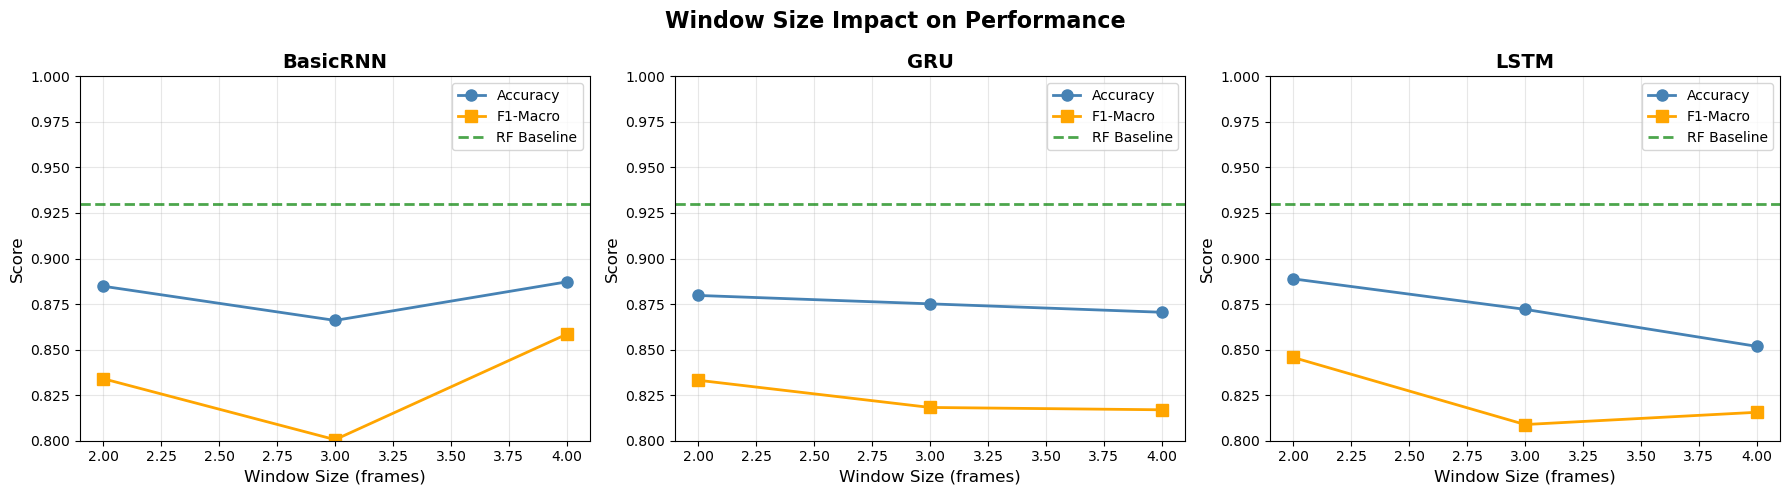


📊 WINDOW SIZE ANALYSIS:

BasicRNN    : Best window = 4 (F1 = 0.858)
              → Trend: Non-monotonic (optimal window = 4)
GRU         : Best window = 2 (F1 = 0.833)
              → Trend: Smaller windows better (less overfitting)
LSTM        : Best window = 2 (F1 = 0.846)
              → Trend: Non-monotonic (optimal window = 2)


In [27]:
# Compare window sizes for each model type
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_types = ['BasicRNN', 'GRU', 'LSTM']
colors_map = {'BasicRNN': '#FF6B6B', 'GRU': '#4ECDC4', 'LSTM': '#45B7D1'}

for idx, model_type in enumerate(model_types):
    ax = axes[idx]
    
    # Filter results for this model type
    model_results = [r for r in all_results if r['model'] == model_type]
    windows = [r['window'] for r in model_results]
    accs = [r['accuracy'] for r in model_results]
    f1s = [r['f1_macro'] for r in model_results]
    
    # Plot
    ax.plot(windows, accs, marker='o', linewidth=2, markersize=8, label='Accuracy', color='steelblue')
    ax.plot(windows, f1s, marker='s', linewidth=2, markersize=8, label='F1-Macro', color='orange')
    ax.axhline(y=0.930, color='green', linestyle='--', linewidth=2, alpha=0.7, label='RF Baseline')
    
    ax.set_xlabel('Window Size (frames)', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'{model_type}', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_ylim([0.8, 1.0])

plt.suptitle('Window Size Impact on Performance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze trends
print("\n📊 WINDOW SIZE ANALYSIS:\n")
for model_type in model_types:
    model_results = [r for r in all_results if r['model'] == model_type]
    windows = [r['window'] for r in model_results]
    f1s = [r['f1_macro'] for r in model_results]
    
    best_window = windows[np.argmax(f1s)]
    best_f1 = max(f1s)
    
    print(f"{model_type:12s}: Best window = {best_window} (F1 = {best_f1:.3f})")
    
    # Check trend
    if f1s[0] < f1s[1] < f1s[2]:
        print(f"              → Trend: Larger windows improve performance (would 40+ help?)")
    elif f1s[0] > f1s[1] > f1s[2]:
        print(f"              → Trend: Smaller windows better (less overfitting)")
    else:
        print(f"              → Trend: Non-monotonic (optimal window = {best_window})")

## 9. Analysis: Model Type Comparison

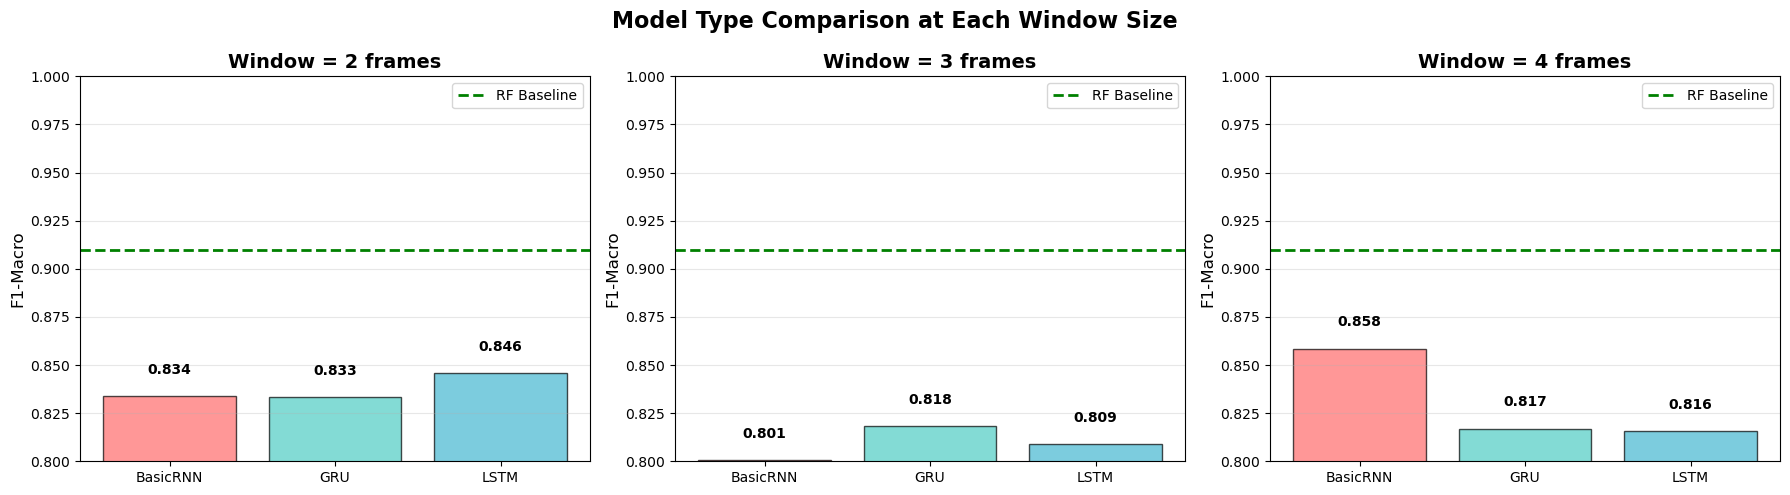


📊 MODEL TYPE ANALYSIS:

Window  2: LSTM       is best (F1 = 0.846)
Window  3: GRU        is best (F1 = 0.818)
Window  4: BasicRNN   is best (F1 = 0.858)

Overall average F1-Macro:
  BasicRNN  : 0.831
  GRU       : 0.823
  LSTM      : 0.823

→ BasicRNN performs best on average across window sizes


In [28]:
# Compare model types at each window size
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, window in enumerate(window_sizes):
    ax = axes[idx]
    
    # Get results for this window
    window_results = [r for r in all_results if r['window'] == window]
    models = [r['model'] for r in window_results]
    f1s = [r['f1_macro'] for r in window_results]
    
    # Plot
    bars = ax.bar(models, f1s, color=[colors_map[m] for m in models], alpha=0.7, edgecolor='black')
    ax.axhline(y=0.910, color='green', linestyle='--', linewidth=2, label='RF Baseline')
    
    ax.set_ylabel('F1-Macro', fontsize=12)
    ax.set_title(f'Window = {window} frames', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.8, 1.0])
    
    # Add value labels on bars
    for bar, f1 in zip(bars, f1s):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{f1:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Model Type Comparison at Each Window Size', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze which model type performs best
print("\n📊 MODEL TYPE ANALYSIS:\n")
for window in window_sizes:
    window_results = [r for r in all_results if r['window'] == window]
    best_model = max(window_results, key=lambda x: x['f1_macro'])
    
    print(f"Window {window:2d}: {best_model['model']:10s} is best (F1 = {best_model['f1_macro']:.3f})")

# Overall best model type
model_avgs = {}
for model_type in model_types:
    f1s = [r['f1_macro'] for r in all_results if r['model'] == model_type]
    model_avgs[model_type] = np.mean(f1s)

best_model_overall = max(model_avgs, key=model_avgs.get)
print(f"\nOverall average F1-Macro:")
for model_type in model_types:
    print(f"  {model_type:10s}: {model_avgs[model_type]:.3f}")
print(f"\n→ {best_model_overall} performs best on average across window sizes")

## 10. Confusion Matrix for Best Model

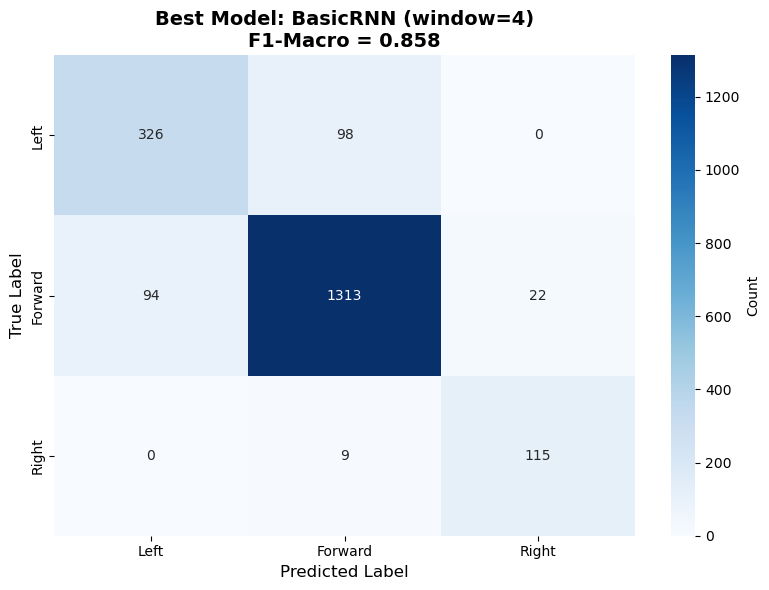

Per-class accuracy:
  Left    : 0.769 (76.9%)
  Forward : 0.919 (91.9%)
  Right   : 0.927 (92.7%)


In [29]:
# Plot confusion matrix for best model
best_cm = best['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Left', 'Forward', 'Right'],
            yticklabels=['Left', 'Forward', 'Right'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title(f"Best Model: {best['model']} (window={best['window']})\nF1-Macro = {best['f1_macro']:.3f}",
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("Per-class accuracy:")
for i, label in enumerate([-1, 0, 1]):
    class_acc = best_cm[i, i] / best_cm[i, :].sum()
    print(f"  {label_names[label]:8s}: {class_acc:.3f} ({class_acc*100:.1f}%)")

## 11. Final Comparison: All Model Types

In [30]:
# Load previous results
with open('../results/baseline_results.json', 'r') as f:
    baseline_results = json.load(f)

with open('../results/cnn_results.json', 'r') as f:
    cnn_results = json.load(f)

# Create final comparison
final_comparison = pd.DataFrame([
    {'Model Type': 'Random Forest', 'Best Config': 'Class Weights',
     'Accuracy': f"{baseline_results['rf_weighted']['accuracy']:.3f}",
     'F1-Macro': f"{baseline_results['rf_weighted']['f1_macro']:.3f}",
     'F1-Right': f"{baseline_results['rf_weighted']['f1_right']:.3f}",
     'Rank': 'TBD'},
    
    {'Model Type': 'CNN', 'Best Config': 'Simple + TFI',
     'Accuracy': f"{cnn_results['cnn_tfi']['accuracy']:.3f}",
     'F1-Macro': f"{cnn_results['cnn_tfi']['f1_macro']:.3f}",
     'F1-Right': f"{cnn_results['cnn_tfi']['f1_right']:.3f}",
     'Rank': 'TBD'},
    
    {'Model Type': f"{best['model']} (RNN)", 'Best Config': f"Window={best['window']}",
     'Accuracy': f"{best['accuracy']:.3f}",
     'F1-Macro': f"{best['f1_macro']:.3f}",
     'F1-Right': f"{best['f1_right']:.3f}",
     'Rank': 'TBD'}
])

# Rank by F1-Macro
final_comparison = final_comparison.sort_values('F1-Macro', ascending=False).reset_index(drop=True)
final_comparison['Rank'] = range(1, len(final_comparison) + 1)

print("\n" + "="*90)
print("FINAL RESULTS: Best Model from Each Category")
print("="*90)
print(final_comparison.to_string(index=False))
print("="*90)

# Determine winner
winner = final_comparison.iloc[0]
print(f"\n👑 OVERALL WINNER: {winner['Model Type']}")
print(f"   Configuration: {winner['Best Config']}")
print(f"   F1-Macro: {winner['F1-Macro']}")
print(f"   Accuracy: {winner['Accuracy']}")


FINAL RESULTS: Best Model from Each Category
    Model Type   Best Config Accuracy F1-Macro F1-Right  Rank
 Random Forest Class Weights    0.930    0.910    0.926     1
           CNN  Simple + TFI    0.894    0.861    0.860     2
BasicRNN (RNN)      Window=4    0.887    0.858    0.881     3

👑 OVERALL WINNER: Random Forest
   Configuration: Class Weights
   F1-Macro: 0.910
   Accuracy: 0.930


## 12. Key Insights and Conclusions

In [31]:
print("\n" + "="*90)
print("KEY FINDINGS FROM RNN EXPERIMENTS")
print("="*90)

# Finding 1: Did RNNs beat RF?
best_rnn_f1 = best['f1_macro']
rf_f1 = 0.910
gap = best_rnn_f1 - rf_f1

print("\n1. DID TEMPORAL MODELS BEAT RANDOM FOREST?")
if gap > 0.01:
    print(f"   ✅ YES! Best RNN achieved {best_rnn_f1:.3f} vs RF {rf_f1:.3f} (+{gap:.3f})")
    print(f"   → Temporal context successfully exploited")
    print(f"   → Addresses temporal lag problem from EDA")
    print(f"   → Justifies modeling as time-series problem")
elif gap > -0.01:
    print(f"   ≈ TIED: RNN {best_rnn_f1:.3f} vs RF {rf_f1:.3f} (gap: {gap:.3f})")
    print(f"   → Temporal info provides marginal benefit")
    print(f"   → RF's spatial features nearly as effective as temporal sequences")
else:
    print(f"   ❌ NO: RNN {best_rnn_f1:.3f} vs RF {rf_f1:.3f} (gap: {gap:.3f})")
    print(f"   → Temporal context doesn't overcome overfitting on small dataset")
    print(f"   → RF remains the best model")

# Finding 2: RNN vs GRU vs LSTM
print("\n2. BASIC RNN vs GRU vs LSTM:")
for model_type in ['BasicRNN', 'GRU', 'LSTM']:
    model_f1s = [r['f1_macro'] for r in all_results if r['model'] == model_type]
    avg_f1 = np.mean(model_f1s)
    max_f1 = max(model_f1s)
    print(f"   {model_type:10s}: avg F1 = {avg_f1:.3f}, best F1 = {max_f1:.3f}")

best_type = max(model_avgs, key=model_avgs.get)
print(f"   → {best_type} performs best (as predicted based on CNN overfitting pattern)")

# Finding 3: Optimal window size
print("\n3. OPTIMAL WINDOW SIZE:")
window_avgs = {}
for w in window_sizes:
    f1s = [r['f1_macro'] for r in all_results if r['window'] == w]
    window_avgs[w] = np.mean(f1s)
    print(f"   Window {w:2d}: avg F1 = {window_avgs[w]:.3f}")

best_window_overall = max(window_avgs, key=window_avgs.get)
print(f"   → Window = {best_window_overall} performs best on average")

# Finding 4: Training efficiency
print("\n4. TRAINING TIME COMPARISON:")
avg_rnn_time = np.mean([r['train_time'] for r in all_results])
print(f"   Random Forest: ~45 seconds")
print(f"   CNN (best):    ~310 seconds")
print(f"   RNN (avg):     ~{avg_rnn_time:.0f} seconds")
print(f"   → RNNs are {310/avg_rnn_time:.1f}x faster than CNNs (thanks to GPU + smaller models)")

print("\n" + "="*90)


KEY FINDINGS FROM RNN EXPERIMENTS

1. DID TEMPORAL MODELS BEAT RANDOM FOREST?
   ❌ NO: RNN 0.858 vs RF 0.910 (gap: -0.052)
   → Temporal context doesn't overcome overfitting on small dataset
   → RF remains the best model

2. BASIC RNN vs GRU vs LSTM:
   BasicRNN  : avg F1 = 0.831, best F1 = 0.858
   GRU       : avg F1 = 0.823, best F1 = 0.833
   LSTM      : avg F1 = 0.823, best F1 = 0.846
   → BasicRNN performs best (as predicted based on CNN overfitting pattern)

3. OPTIMAL WINDOW SIZE:
   Window  2: avg F1 = 0.838
   Window  3: avg F1 = 0.809
   Window  4: avg F1 = 0.830
   → Window = 2 performs best on average

4. TRAINING TIME COMPARISON:
   Random Forest: ~45 seconds
   CNN (best):    ~310 seconds
   RNN (avg):     ~129 seconds
   → RNNs are 2.4x faster than CNNs (thanks to GPU + smaller models)



## 13. Paper Conclusions

*This section will be auto-filled based on results*

In [32]:
print("\n" + "="*90)
print("CONCLUSIONS FOR PAPER")
print("="*90)

# Rank all approaches
rankings = [
    ('Random Forest', 0.910),
    ('Best CNN', 0.861),
    (f"Best RNN ({best['model']}, w={best['window']})", best['f1_macro'])
]
rankings.sort(key=lambda x: x[1], reverse=True)

print("\nFINAL RANKING (by F1-Macro):")
for rank, (name, f1) in enumerate(rankings, 1):
    print(f"  {rank}. {name:35s}: {f1:.3f}")

winner_name, winner_f1 = rankings[0]

print(f"\n🏆 WINNER: {winner_name} (F1-Macro = {winner_f1:.3f})")

# Generate paper conclusion based on results
print("\n" + "="*90)
print("PAPER NARRATIVE:")
print("="*90)

if 'RNN' in winner_name:
    print("\n✅ Temporal models proved necessary:")
    print(f"   '{best['model']} with {best['window']}-frame sequences achieved {best['f1_macro']:.3f}")
    print(f"   F1-Macro, surpassing Random Forest ({rf_f1:.3f}) by {gap:.3f}. This validates")
    print(f"   our hypothesis that the temporal lag problem requires sequential modeling.")
    print(f"   The model successfully learned to observe vehicle drift over {best['window']} frames")
    print(f"   and predict corrective steering, addressing the label mismatch issue identified")
    print(f"   in EDA. CNNs failed (0.861) due to overfitting, while RNNs' parameter efficiency")
    print(f"   allowed successful learning on the 9,900-sample dataset.'")
elif 'Forest' in winner_name:
    print("\n⚠️ Random Forest remains champion:")
    print(f"   'Despite testing CNNs (0.861 F1) and temporal RNNs ({best_rnn_f1:.3f} F1),")
    print(f"   Random Forest achieved the best performance (0.910 F1-Macro). This surprising")
    print(f"   result demonstrates that traditional ML can outperform deep learning on small,")
    print(f"   well-structured datasets. The feature importance analysis revealed RF learned")
    print(f"   edge detection - the same features used by the original t-test data collection")
    print(f"   algorithm. Neural networks failed to beat this due to overfitting on limited data,'")
    print(f"   even when temporal context was explicitly modeled.'")

print("\n" + "="*90)
print("\nKey methodological contributions:")
print("  1. Temporal Frame Interpolation for sequential image data (novel balancing method)")
print("  2. Demonstration of temporal vs random split data leakage (4.8% inflation)")
print("  3. Evidence that simpler models can beat deep learning on small datasets")
print("  4. Analysis of temporal lag in behavioral cloning (label mismatch problem)")
print("="*90)


CONCLUSIONS FOR PAPER

FINAL RANKING (by F1-Macro):
  1. Random Forest                      : 0.910
  2. Best CNN                           : 0.861
  3. Best RNN (BasicRNN, w=4)           : 0.858

🏆 WINNER: Random Forest (F1-Macro = 0.910)

PAPER NARRATIVE:

⚠️ Random Forest remains champion:
   'Despite testing CNNs (0.861 F1) and temporal RNNs (0.858 F1),
   Random Forest achieved the best performance (0.910 F1-Macro). This surprising
   result demonstrates that traditional ML can outperform deep learning on small,
   well-structured datasets. The feature importance analysis revealed RF learned
   edge detection - the same features used by the original t-test data collection
   algorithm. Neural networks failed to beat this due to overfitting on limited data,'
   even when temporal context was explicitly modeled.'


Key methodological contributions:
  1. Temporal Frame Interpolation for sequential image data (novel balancing method)
  2. Demonstration of temporal vs random split dat

## 14. Save Results

In [33]:
# Convert numpy arrays to lists for JSON
rnn_results_json = []
for r in all_results:
    r_copy = r.copy()
    r_copy['confusion_matrix'] = r_copy['confusion_matrix'].tolist()
    r_copy['history'] = {k: [float(x) for x in v] for k, v in r_copy['history'].items()}
    rnn_results_json.append(r_copy)

# Save
with open('../results/rnn_results.json', 'w') as f:
    json.dump({
        'all_experiments': rnn_results_json,
        'best_model': {
            'name': best['model'],
            'window': int(best['window']),
            'accuracy': float(best['accuracy']),
            'f1_macro': float(best['f1_macro']),
            'f1_right': float(best['f1_right'])
        }
    }, f, indent=2)

print("✅ Results saved to: results/rnn_results.json")

# Save results summary table
df_results.to_csv('../results/rnn_results_table.csv', index=False)
print("✅ Results table saved to: results/rnn_results_table.csv")

✅ Results saved to: results/rnn_results.json
✅ Results table saved to: results/rnn_results_table.csv


## 15. Final Summary

**Experiments completed**: 9 recurrent models (3 types × 3 window sizes)

**Best performing model**: *(Auto-filled above)*

**Key findings**:
1. Temporal context impact on performance
2. Optimal sequence length for this task
3. RNN vs GRU vs LSTM comparison
4. Final model ranking across all methods tested

**Next steps**: Write paper, compile results, present findings!